----------------------------LOS VALORES DE ANÁLISIS DE ESTE CÓDIGO NO DEPENDEN DE LA PENDIENTE-------------------------------------

Librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Datos y constantes

In [3]:
# Datos
V = np.array([2.0, 2.4, 2.8, 3.2, 3.6, 4.0, 4.4, 4.8]) * 1000  # Voltaje en V
R_1 = np.array([2.120, 1.860, 1.750, 1.600, 1.400, 1.315, 1.290, 1.240]) * 2e-2  # en m
R_2 = np.array([3.330, 3.155, 2.835, 2.675, 2.360, 2.225, 2.140, 2.040]) * 2e-2  # en m
incer_d_1 = np.array([0.270, 0.275, 0.280, 0.250, 0.170, 0.245, 0.235, 0.185]) * 1e-2  # en m
incer_d_2 = np.array([0.360, 0.280, 0.290, 0.280, 0.222, 0.205, 0.165, 0.170]) * 1e-2  # en m
incer_V = 100  # Incertidumbre en V

# Cálculo de 1/sqrt(V)
Raiz_v = 1 / np.sqrt(V)

# Constantes
h = 6.62607015e-34  # J*s
m_e = 9.10938356e-31  # kg
e = 1.602176634e-19  # C
L = 0.135  # m, distancia tubo-pantalla
D1 = 213e-12  # m
D2 = 123e-12  # m
n = 1  # Orden de difracción asumido

Lambda de Broglie

In [4]:
def lambda_broglie (V_v):
    l_broglie = (h / (np.sqrt(2 * m_e * e * V_v)))
    return l_broglie

def incer_lambda_broglie (V_v):
    incer_V = 0.1
    return h / (2*np.sqrt(2 * m_e * e * V_v**3)) * incer_V

#longitud_de_onda(V_v)
#incer_lambda_broglie(V_v)

Lambda de Bragg

In [5]:
def lambda_bragg(D, d):
    theta = 0.5 * np.arctan(D / (2 * L))
    return (2 * d * np.sin(theta))

def incer_lambda_bragg (D, d):
    incer_d = 0.01
    return ((2 * D * np.cos(0.5 * np.arctan(d / (2 * 0.135))) * 1/(2*(1+(1/2*0.135)**2*d**2 * 2*0.135))) * incer_d)

lambda1_bragg = lambda_bragg(R_1, D1)
lambda2_bragg = lambda_bragg(R_2, D2)

Comprobación de la ecuación de de Broglie concerniente a la longitud de onda de los electrones.

In [6]:
def error (D, d, V):
    return np.abs(((lambda_bragg(d, D) - lambda_broglie(V))/ lambda_broglie(V)) * 100)

error(D2, R_2, V)

array([ 8.20471143, 12.55251271,  9.65316159, 10.80177384,  4.01227405,
        3.49520526,  4.47782661,  4.11188406])

Gráfica con pesos

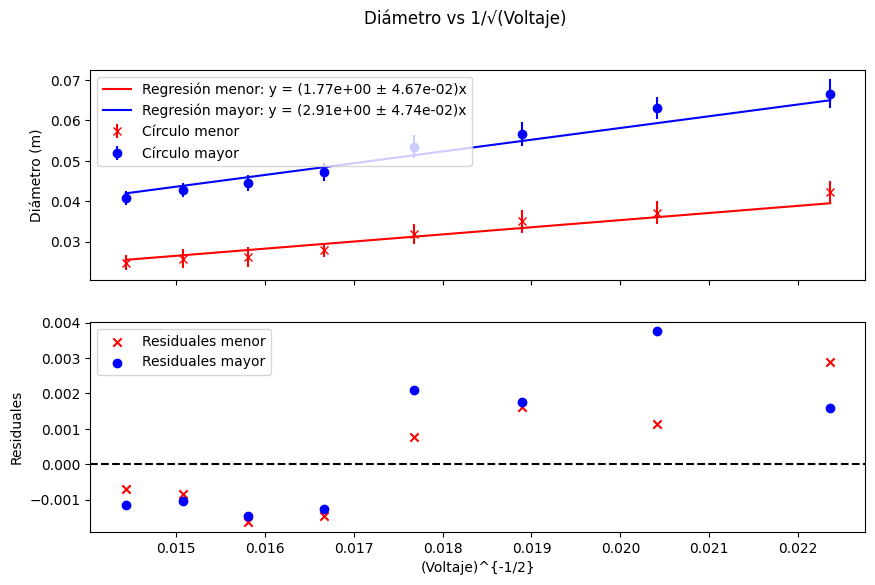

In [7]:
# Función lineal para ajuste
def linear_fit(x, m):
    return m * x

# Ajuste lineal con pesos
popt1, pcov1 = curve_fit(linear_fit, Raiz_v, R_1, sigma=incer_d_1, absolute_sigma=True)
popt2, pcov2 = curve_fit(linear_fit, Raiz_v, R_2, sigma=incer_d_2, absolute_sigma=True)

m1, m2 = popt1[0], popt2[0]
error_m1, error_m2 = np.sqrt(np.diag(pcov1))[0], np.sqrt(np.diag(pcov2))[0]

# Gráfica
_x = np.linspace(np.min(Raiz_v), np.max(Raiz_v), 100)
_y1 = linear_fit(_x, m1)
_y2 = linear_fit(_x, m2)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Diámetro vs 1/√(Voltaje)')
axs[0].errorbar(Raiz_v, R_1, yerr=incer_d_1, fmt='rx', label='Círculo menor')
axs[0].plot(_x, _y1, 'r-', label=f'Regresión menor: y = ({m1:.2e} ± {error_m1:.2e})x')
axs[0].errorbar(Raiz_v, R_2, yerr=incer_d_2, fmt='bo', label='Círculo mayor')
axs[0].plot(_x, _y2, 'b-', label=f'Regresión mayor: y = ({m2:.2e} ± {error_m2:.2e})x')
axs[0].set_ylabel('Diámetro (m)')
axs[0].legend()

# Residuales
R1_res = R_1 - linear_fit(Raiz_v, m1)
R2_res = R_2 - linear_fit(Raiz_v, m2)
axs[1].scatter(Raiz_v, R1_res, color='red', marker='x', label='Residuales menor')
axs[1].scatter(Raiz_v, R2_res, color='blue', marker='o', label='Residuales mayor')
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('(Voltaje)^{-1/2}')
axs[1].set_ylabel('Residuales')
axs[1].legend()
plt.show()


Distancias interplanares

In [8]:
def calcular_d(lambda_b, theta):
    return (n * lambda_b) / (2 * np.sin(theta))

theta1 = 0.5 * np.arctan(R_1 / (2 * L))
theta2 = 0.5 * np.arctan(R_2 / (2 * L))
d1_calc = calcular_d(lambda1_bragg, theta1)
d2_calc = calcular_d(lambda2_bragg, theta2)

# Propagación de incertidumbre en d
def incertidumbre_d(lambda_b, theta, incer_lambda):
    return np.abs((n / (2 * np.sin(theta))) * incer_lambda)

incer_d1 = incertidumbre_d(lambda1_bragg, theta1, incer_d_1)
incer_d2 = incertidumbre_d(lambda2_bragg, theta2, incer_d_2)

print(f'd1 calculado: {np.mean(d1_calc):.2e} ± {np.mean(incer_d1):.2e} m (vs {D1} m)')
print(f'd2 calculado: {np.mean(d2_calc):.2e} ± {np.mean(incer_d2):.2e} m (vs {D2} m)')

d1 calculado: 2.13e-10 ± 2.09e-02 m (vs 2.13e-10 m)
d2 calculado: 1.23e-10 ± 1.28e-02 m (vs 1.23e-10 m)


Constante de Planck

In [9]:
def hallar_h(lambda_b, V):
    return lambda_b * np.sqrt(2 * m_e * e * V)

def incertidumbre_h(lambda_b, V, incer_lambda, incer_V):
    return np.sqrt((lambda_b*np.sqrt(2*m_e*e)/(2*0.135))**2 * 1**2)
h_calc1 = hallar_h(lambda1_bragg, V)
h_calc2 = hallar_h(lambda2_bragg, V)
incer_h1 = incertidumbre_h(lambda1_bragg, V, incer_d_1, incer_V)
incer_h2 = incertidumbre_h(lambda2_bragg, V, incer_d_2, incer_V)

print(f'h calculado círculo menor: {np.mean(h_calc1):.4e} ± {np.mean(incer_h1):.4e} J·s')
print(f'h calculado círculo mayor: {np.mean(h_calc2):.4e} ± {np.mean(incer_h2):.4e} J·s')

h calculado círculo menor: 7.5008e-34 ± 4.9350e-35 J·s
h calculado círculo mayor: 7.1007e-34 ± 4.6615e-35 J·s
